In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
df = air_quality.data.features 

In [3]:
# Convert 'Date' and 'Time' columns to datetime format
df['DateTime'] = pd.to_datetime(df['Date']+ ' ' + df['Time'])
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Drop Date and Time columns
df.drop(columns=['Time','Date'], inplace=True)

In [4]:
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Year,Month,Day
Date,,,,,,,,,,,,,,,,,
2004-03-10,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,2004-03-10 18:00:00,2004,3,10
2004-03-10,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,2004-03-10 19:00:00,2004,3,10
2004-03-10,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,2004-03-10 20:00:00,2004,3,10
2004-03-10,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,2004-03-10 21:00:00,2004,3,10
2004-03-10,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,2004-03-10 22:00:00,2004,3,10


In [5]:
year = pd.DataFrame(df.groupby(['Date'])['CO(GT)'].mean())
year.index = pd.DatetimeIndex(year.index, freq=year.index.inferred_freq)
year.head()

,CO(GT)
Date,
2004-03-10,1.966667
2004-03-11,-6.187500
2004-03-12,-14.095833
2004-03-13,-5.750000
2004-03-14,-5.966667


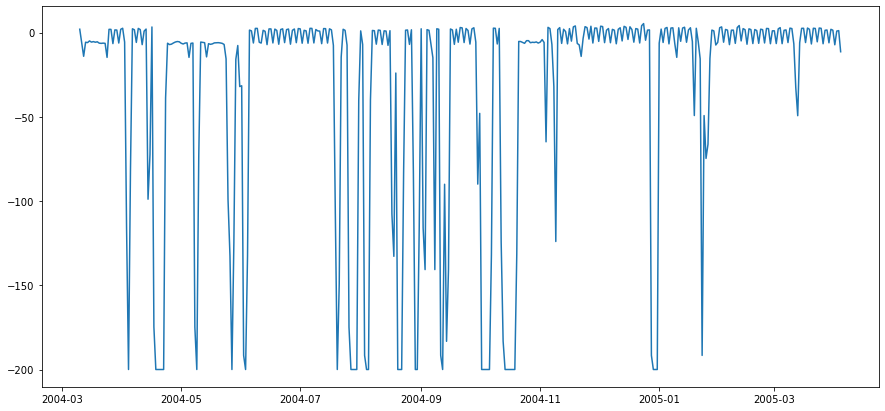

In [6]:
plt.figure(figsize = (15,7))
plt.plot(year, label = 'Average CO2 by Day')
plt.show()

In [7]:
adf_test = adfuller(year['CO(GT)'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -8.748258
p-value: 0.000000


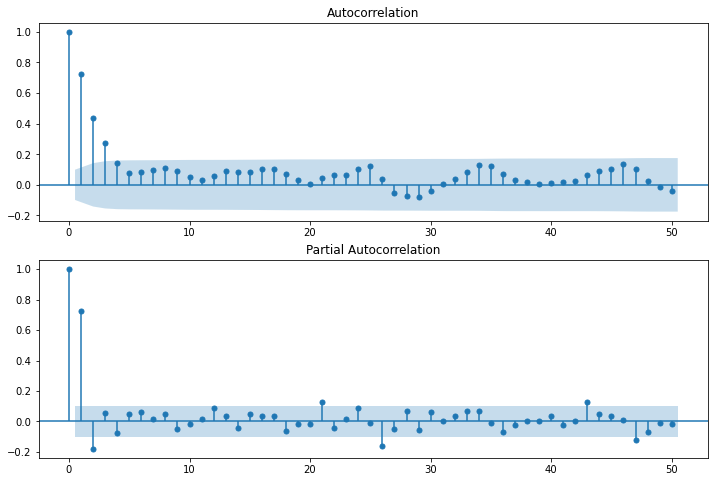

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(year['CO(GT)'], lags = 50, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(year['CO(GT)'],lags=50,ax=ax2)

In [9]:
mod = ARIMA(year['CO(GT)'], order = (2,0,2))
fit = mod.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 CO(GT)   No. Observations:                  391
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2042.572
Date:                Wed, 03 Jul 2024   AIC                           4097.144
Time:                        20:06:23   BIC                           4120.957
Sample:                    03-10-2004   HQIC                          4106.583
                         - 04-04-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.0107     14.572     -2.334      0.020     -62.571      -5.450
ar.L1         -0.3085      0.548     -0.563      0.573      -1.382       0.765
ar.L2          0.5399      0.305      1.768      0.0

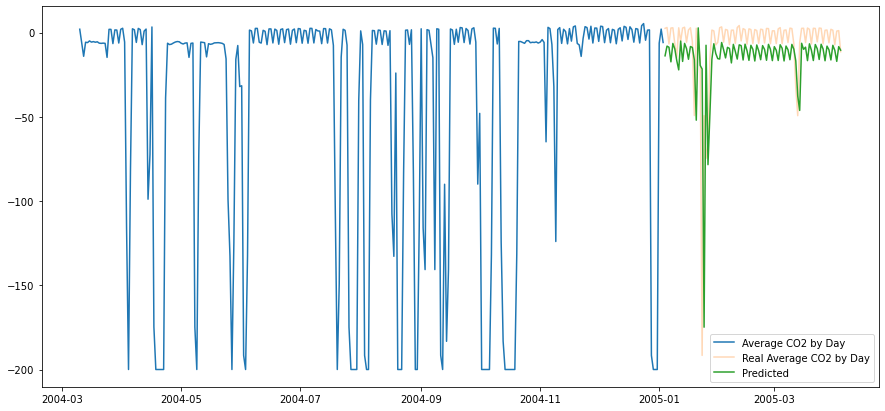

MAE: 15.271274917815404


In [10]:
year['forecast']=fit.predict(start=300)

plt.figure(figsize = (15,7))
plt.plot(year.iloc[:300]['CO(GT)'], label = 'Average CO2 by Day')
plt.plot(year.iloc[300:]['CO(GT)'], label = 'Real Average CO2 by Day', alpha = .3)
plt.plot(year['forecast'], label = 'Predicted')
plt.legend()
plt.show()
print('MAE:',metrics.mean_absolute_error(year.iloc[300:]['CO(GT)'],year.iloc[300:]['forecast']))

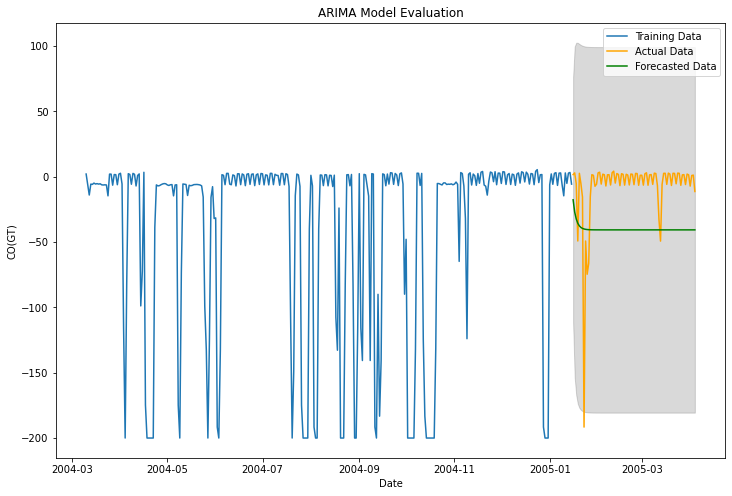

RMSE: 41.310347660980455


In [11]:
#https://medium.com/datainc/time-series-analysis-and-forecasting-with-arima-in-python-aa22694b3aaa

# Split the data into train and test
train_size = int(len(year) * 0.8)
train, test = year[0:train_size], year[train_size:len(year)]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['CO(GT)'], order=(2, 0, 2))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = metrics.mean_squared_error(test['CO(GT)'], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(12,8))
plt.plot(train['CO(GT)'], label='Training Data')
plt.plot(test['CO(GT)'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('CO(GT)')
plt.legend()
plt.show()

print('RMSE:', rmse)

In [12]:
mod = ARIMA(year['CO(GT)'], order = (2,0,4))
fit = mod.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 CO(GT)   No. Observations:                  391
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -2040.848
Date:                Wed, 03 Jul 2024   AIC                           4097.695
Time:                        20:06:24   BIC                           4129.445
Sample:                    03-10-2004   HQIC                          4110.280
                         - 04-04-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.0910     13.885     -2.455      0.014     -61.305      -6.877
ar.L1         -0.1952      0.305     -0.640      0.522      -0.793       0.403
ar.L2          0.2474      0.253      0.976      0.3

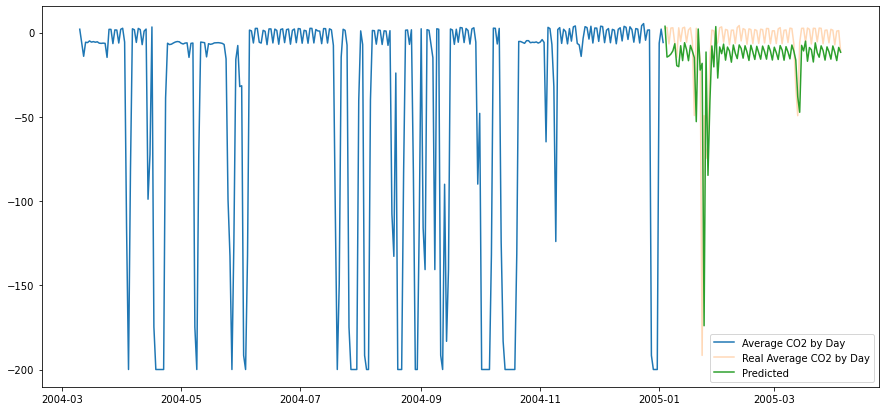

MAE: 15.750089920820542


In [13]:
year['forecast']=fit.predict(start=300)

plt.figure(figsize = (15,7))
plt.plot(year.iloc[:300]['CO(GT)'], label = 'Average CO2 by Day')
plt.plot(year.iloc[300:]['CO(GT)'], label = 'Real Average CO2 by Day', alpha = .3)
plt.plot(year['forecast'], label = 'Predicted')
plt.legend()
plt.show()
print('MAE:',metrics.mean_absolute_error(year.iloc[300:]['CO(GT)'],year.iloc[300:]['forecast']))

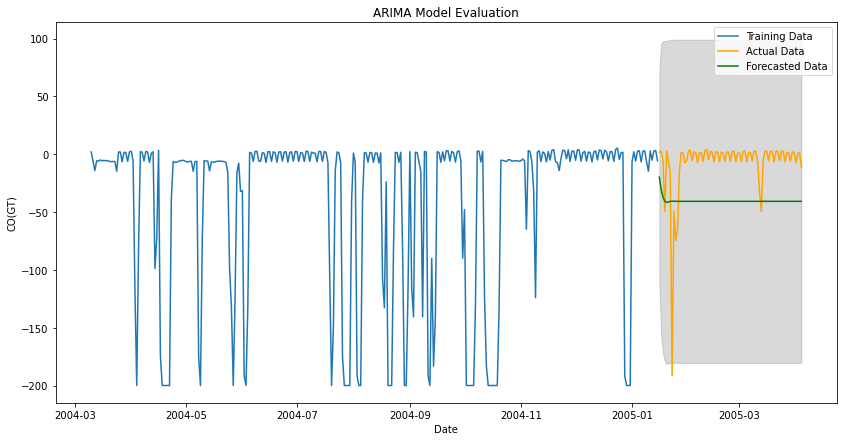

RMSE: 41.4507992420051


In [14]:
#https://medium.com/datainc/time-series-analysis-and-forecasting-with-arima-in-python-aa22694b3aaa

# Split the data into train and test
train_size = int(len(year) * 0.8)
train, test = year[0:train_size], year[train_size:len(year)]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['CO(GT)'], order=(2, 0, 4))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = metrics.mean_squared_error(test['CO(GT)'], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['CO(GT)'], label='Training Data')
plt.plot(test['CO(GT)'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('CO(GT)')
plt.legend()
plt.show()

print('RMSE:', rmse)

In [15]:
mod = ARIMA(year['CO(GT)'], order = (3,0,4))
fit = mod.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 CO(GT)   No. Observations:                  391
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -2037.768
Date:                Wed, 03 Jul 2024   AIC                           4093.535
Time:                        20:06:25   BIC                           4129.253
Sample:                    03-10-2004   HQIC                          4107.693
                         - 04-04-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.0837     13.919     -2.449      0.014     -61.364      -6.804
ar.L1          1.4409      0.105     13.754      0.000       1.236       1.646
ar.L2         -1.4472      0.096    -15.121      0.0

/Users/zanderbonnet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


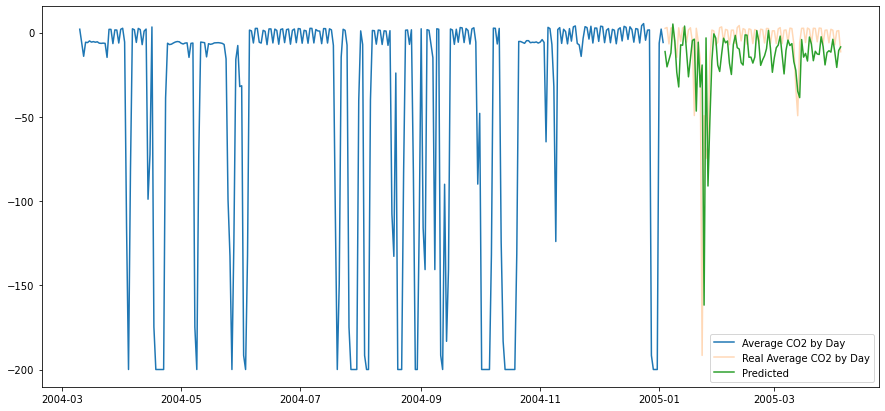

MAE: 15.932133664626555


In [16]:
year['forecast']=fit.predict(start=300)

plt.figure(figsize = (15,7))
plt.plot(year.iloc[:300]['CO(GT)'], label = 'Average CO2 by Day')
plt.plot(year.iloc[300:]['CO(GT)'], label = 'Real Average CO2 by Day', alpha = .3)
plt.plot(year['forecast'], label = 'Predicted')
plt.legend()
plt.show()
print('MAE:',metrics.mean_absolute_error(year.iloc[300:]['CO(GT)'],year.iloc[300:]['forecast']))

/Users/zanderbonnet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


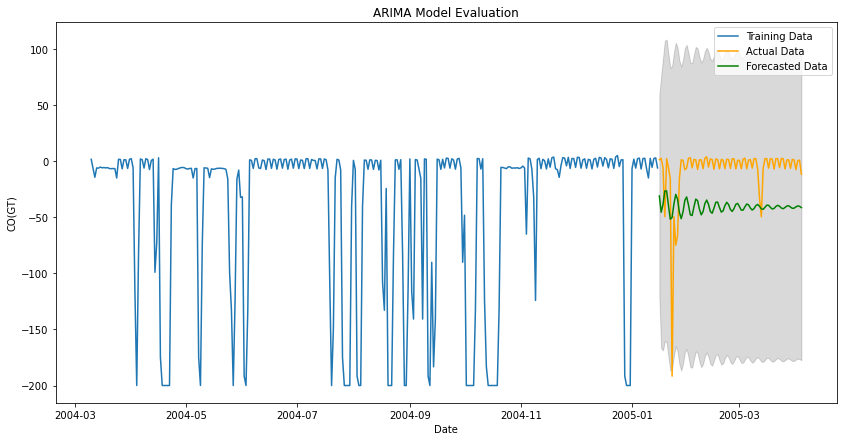

RMSE: 41.70866896770278


In [17]:
#https://medium.com/datainc/time-series-analysis-and-forecasting-with-arima-in-python-aa22694b3aaa

# Split the data into train and test
train_size = int(len(year) * 0.8)
train, test = year[0:train_size], year[train_size:len(year)]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['CO(GT)'], order=(3, 0, 4))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = metrics.mean_squared_error(test['CO(GT)'], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['CO(GT)'], label='Training Data')
plt.plot(test['CO(GT)'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('CO(GT)')
plt.legend()
plt.show()

print('RMSE:', rmse)